In [83]:
import pandas as pd
from PIL import Image, ImageFile
from scipy import ndimage

import os
from time import time
from joblib import Parallel, delayed
ImageFile.LOAD_TRUNCATED_IMAGES = True

import numpy as np
import pydicom
from scipy import ndimage
from PIL import Image, ImageFile
import matplotlib.pylab as plt
from tqdm import tqdm_notebook, tqdm
%matplotlib inline

base_url = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/'
TRAIN_DIR = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/stage_2_train'
TEST_DIR = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/stage_2_test'
os.listdir(base_url)

['stage_2_test_triplets.csv',
 'train_triplets.csv',
 'png',
 'stage_2_test',
 'stage_2_train',
 'stage_2_train.csv',
 'test_metadata.parquet.gzip',
 'stage_2_sample_submission.csv',
 'train_metadata.parquet.gzip']

In [2]:
train_metadata = pd.read_parquet(f'{base_url}/train_metadata.parquet.gzip')
test_metadata = pd.read_parquet(f'{base_url}/test_metadata.parquet.gzip')

In [39]:
def build_triplets(metadata):
    metadata.sort_values(by="ImagePositionPatient_2", inplace=True, ascending=False)
    studies = metadata.groupby("StudyInstanceUID")
    triplets = []

    for study_name, study_df in tqdm_notebook(studies):
        padded_names = np.pad(study_df.index, (1, 1), 'edge')

        for i, img in enumerate(padded_names[1:-1]):
            t = [padded_names[i], img, padded_names[i + 2]]
            triplets.append(t)

    return pd.DataFrame(triplets, columns=["red", "green", "blue"])

In [40]:
train_triplets = build_triplets(train_metadata)
test_triplets = build_triplets(test_metadata)


/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [71]:
train_triplets.to_csv("train_triplets.csv")
test_triplets.to_csv("stage_2_test_triplets.csv")

In [72]:
train_triplets.head()

,red,green,blue
0,ID_ed600c22e,ID_ed600c22e,ID_087208a31
1,ID_ed600c22e,ID_087208a31,ID_506d20418
2,ID_087208a31,ID_506d20418,ID_3e299291c
3,ID_506d20418,ID_3e299291c,ID_39ba043b0
4,ID_3e299291c,ID_39ba043b0,ID_eec846575


In [67]:
def prepare_dicom(dcm, width=None, level=None, norm=True):
    """
    Converts a DICOM object to a 16-bit Numpy array (in Hounsfield units)
    :param dcm: DICOM Object
    :return: Numpy array in int16
    """

    try:
        # https://www.kaggle.com/jhoward/cleaning-the-data-for-rapid-prototyping-fastai
        if dcm.BitsStored == 12 and dcm.PixelRepresentation == 0 and dcm.RescaleIntercept > -100:
            x = dcm.pixel_array + 1000
            px_mode = 4096
            x[x >= px_mode] = x[x >= px_mode] - px_mode
            dcm.PixelData = x.tobytes()
            dcm.RescaleIntercept = -1000

        pixels = dcm.pixel_array.astype(np.float32) * dcm.RescaleSlope + dcm.RescaleIntercept
    except ValueError as e:
        print("ValueError with", dcm.SOPInstanceUID, e)
        return np.zeros((512, 512))

    # Pad the image if it isn't square
    if pixels.shape[0] != pixels.shape[1]:
        (a, b) = pixels.shape
        if a > b:
            padding = ((0, 0), ((a - b) // 2, (a - b) // 2))
        else:
            padding = (((b - a) // 2, (b - a) // 2), (0, 0))
        pixels = np.pad(pixels, padding, mode='constant', constant_values=0)
        
    if not width:
        width = dcm.WindowWidth
        if type(width) != pydicom.valuerep.DSfloat:
            width = width[0]
    if not level:
        level = dcm.WindowCenter
        if type(level) != pydicom.valuerep.DSfloat:
            level = level[0]
    lower = level - (width / 2)
    upper = level + (width / 2)
    img = np.clip(pixels, lower, upper)

    if norm:
        return (img - lower) / (upper - lower)
    else:
        return img

In [68]:
channels = train_triplets.iloc[379]
channels

red      ID_f9ddf8034
green    ID_fe2dd6f48
blue     ID_fe2dd6f48
Name: 379, dtype: object

In [69]:
rgb = []

for image_id in channels:
    dcm = pydicom.dcmread(os.path.join(base_url, "stage_2_train", image_id + ".dcm"))
    rgb.append(prepare_dicom(dcm))
    
img = np.stack(rgb, -1)
img = np.clip(img, 0, 255).astype(np.uint8) 

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(img);

In [56]:
labeled_blobs, number_of_blobs = ndimage.label(img)
blob_sizes = np.bincount(labeled_blobs.flatten())
number_of_blobs

64

In [57]:
blob_sizes

array([572796, 196067,      2,      2,      2,      2,      4,      2,
            2,     56,     42,      1,      1,      1,      5,      4,
            1,      1,      1,    746,      1,      1,      1,      1,
           10,    691,      8,     26,     12,      8,     46,      2,
          406,      6,      9,      6,      7,  15301,      2,      2,
            2,      4,      2,     16,      2,     18,      2,      4,
           12,      2,      2,      1,      1,      6,      1,      4,
            1,      2,      1,      6,      4,      6,      1,     44,
            4])

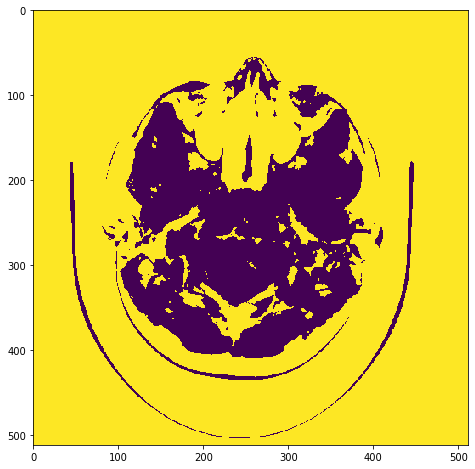

In [58]:
blob_0 = labeled_blobs == 0  # label 0 has 593185 connected pixels
blob_0 = np.max(blob_0, axis=-1)

plt.figure(figsize=(8, 8))
plt.imshow(blob_0);

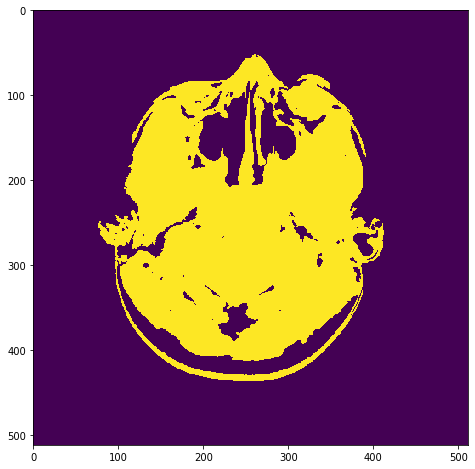

In [59]:
blob_1 = labeled_blobs == 1  # label 1 has 173243 connected pixels
blob_1 = np.max(blob_1, axis=-1)

plt.figure(figsize=(8, 8))
plt.imshow(blob_1);

In [60]:
class CropHead(object):
    def __init__(self, offset=10):
        """
        Crops the head by labelling the objects in an image and keeping the second largest object (the largest object
        is the background). This method removes most of the headrest

        Originally made as a image transform for use with PyTorch, but too slow to run on the fly :(
        :param offset: Pixel offset to apply to the crop so that it isn't too tight
        """
        self.offset = offset

    def crop_extents(self, img):
        try:
            if type(img) != np.array:
                img_array = np.array(img)
            else:
                img_array = img

            labeled_blobs, number_of_blobs = ndimage.label(img_array)
            blob_sizes = np.bincount(labeled_blobs.flatten())
            head_blob = labeled_blobs == np.argmax(blob_sizes[1:]) + 1  # The number of the head blob
            head_blob = np.max(head_blob, axis=-1)

            mask = head_blob == 0
            rows = np.flatnonzero((~mask).sum(axis=1))
            cols = np.flatnonzero((~mask).sum(axis=0))

            x_min = max([rows.min() - self.offset, 0])
            x_max = min([rows.max() + self.offset + 1, img_array.shape[0]])
            y_min = max([cols.min() - self.offset, 0])
            y_max = min([cols.max() + self.offset + 1, img_array.shape[1]])

            return x_min, x_max, y_min, y_max
        except ValueError:
            return 0, 0, -1, -1

    def __call__(self, img):
        """
        Crops a CT image to so that as much black area is removed as possible
        :param img: PIL image
        :return: Cropped image
        """

        x_min, x_max, y_min, y_max = self.crop_extents(img)

        try:
            if type(img) != np.array:
                img_array = np.array(img)
            else:
                img_array = img

            return Image.fromarray(np.uint8(img_array[x_min:x_max, y_min:y_max]))
        except ValueError:
            return img

    def __repr__(self):
        return self.__class__.__name__ + '(offset={})'.format(self.offset)

In [61]:
crop_head = CropHead()
img_cropped = crop_head(img)

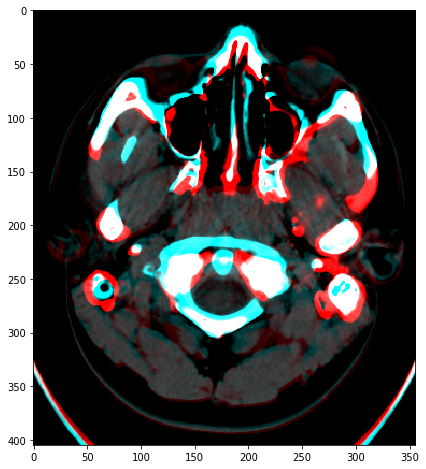

In [62]:
plt.figure(figsize=(8, 8))
plt.imshow(img_cropped);